# RSI momentum trading strategy example

- This is a backtest example notebook
    - Replace BTC and ETH with MATIC and ETH for Polygon/Enzyme
    - Limited search space to make running faster
    - We have intentionally culled 2021 bull run out, because it makes MATIC results hard to compare (it's unlikely such bull run will happen for MATIC again)

# Set up

Set up Trading Strategy data client.

In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()


# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
# etup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [2]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["ETHUSDT", "MATICUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.h8,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2022, 6, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 3, 10),
    include_lending=False
)

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
    (ChainId.centralised_exchange, "binance", "MATIC", "USDT"),
]


  0%|          | 0/2 [00:00<?, ?it/s]

# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [3]:
from tradingstrategy.chain import ChainId

pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 3,890 candles.
Pair <Pair #1 ETH - USDT at exchange binance> first close price 1930.71 at 2022-06-01 00:00:00
Pair <Pair #2 MATIC - USDT at exchange binance> first close price 0.643 at 2022-06-01 00:00:00


# Indicators

- Prepare indicators needed for the grid

In [4]:
import pandas_ta
import pandas as pd

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_price_series


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_matic_eth(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price, upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price, upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_btc / resampled_eth  # Divide two series
    return series


def calculate_matic_eth(strategy_universe: TradingStrategyUniverse):
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return series


def calculate_matic_eth_rsi(strategy_universe: TradingStrategyUniverse, length: int):
    weth_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WETH", "USDC"))
    wbtc_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WBTC", "USDC"))
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(wbtc_usdc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(weth_usdc.internal_id)
    matic_eth = eth_price["close"] / btc_price["close"]
    return pandas_ta.rsi(matic_eth, length=length)


def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("matic_eth", calculate_shifted_matic_eth, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    indicators.add("matic_eth_rsi", calculate_matic_eth_rsi, parameters={"length": parameters.matic_eth_rsi_bars}, source=IndicatorSource.strategy_universe)

# Trading algorithm

In [5]:
import pandas as pd

from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.strategy.weighting import weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # Resolve our pair metadata for our two pair strategy
    parameters = input.parameters 
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    shift = parameters.shift
    clock_shift = pd.Timedelta(hours=1) * shift

    # Execute the daily trade cycle when the clock hour 0..24 is correct for our hourly shift
    assert parameters.upsample.to_timedelta() >= parameters.cycle_duration.to_timedelta(), "Upsample period must be longer than cycle period"    
    assert shift <= 0  # Shift -1 = do action 1 hour later

    # Do the clock shift trick
    if parameters.cycle_duration.to_timedelta() != parameters.upsample.to_timedelta():
        if (input.cycle - 1 + shift) % int(parameters.upsample.to_hours()) != 0:
            return []

    alpha_model = AlphaModel(input.timestamp)
    eth_pair = position_manager.get_trading_pair(our_pairs[0])
    matic_pair = position_manager.get_trading_pair(our_pairs[1])    
    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {matic_pair: 0, eth_pair: 0}
    matic_eth_rsi_yesterday = None

    for pair in [matic_pair, eth_pair]:        
        current_price[pair] = indicators.get_price(pair)

        current_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-1, pair=pair, clock_shift=clock_shift)
        previous_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-2, pair=pair, clock_shift=clock_shift)

        if shift and input.cycle > 100:
            indicators.get_indicator_value("rsi", index=-1 + shift, pair=pair, clock_shift=clock_shift)

    matic_eth_yesterday = indicators.get_indicator_value("matic_eth", clock_shift=clock_shift)
    matic_eth_rsi_yesterday = indicators.get_indicator_value("matic_eth_rsi", clock_shift=clock_shift)
    if matic_eth_rsi_yesterday is not None:
        matic_momentum = (matic_eth_rsi_yesterday / 100) + 0.5 
        eth_momentum = (1 - (matic_eth_rsi_yesterday / 100)) + 0.5
        momentum[eth_pair] = eth_momentum ** parameters.momentum_exponent
        momentum[matic_pair] = matic_momentum ** parameters.momentum_exponent

    #
    # Trading logic
    #

    for pair in [matic_pair, eth_pair]:
        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            rsi_cross_above = current_rsi_values[pair] >= parameters.rsi_high and previous_rsi_values[pair] < parameters.rsi_high
            rsi_cross_below = current_rsi_values[pair] < parameters.rsi_low and previous_rsi_values[pair] > parameters.rsi_low

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)
            else:
                # We have open position, check for the close condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Enable trailing stop loss if we have reached the activation level
    if parameters.trailing_stop_loss_activation_level is not None:
       for p in state.portfolio.open_positions.values():
           if p.trailing_stop_loss_pct is None:
               if current_price[p.pair] >= p.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                   p.trailing_stop_loss_pct = parameters.trailing_stop_loss

    # Use alpha model and construct a portfolio of two assets
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.minimum_rebalance_trade_percent * portfolio.get_total_equity(),
    )

    #
    # Visualisations
    #

    if input.is_visualisation_enabled():

        visualisation = state.visualisation  # Helper class to visualise strategy output

        # BTC RSI daily
        if current_rsi_values[matic_pairirir]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI BTC",
                PlotKind.technical_indicator_detached,
                current_rsi_values[matic_pair],
                colour="orange",
            )


            # Low (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI low trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_low,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

            # High (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI high trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_high,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

        # ETH RSI daily
        if current_rsi_values[eth_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI ETH",
                PlotKind.technical_indicator_overlay_on_detached,
                current_rsi_values[eth_pair],
                colour="blue",
                label=PlotLabel.hidden,
                detached_overlay_name=f"RSI BTC",
            )

        if matic_eth_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC",
                PlotKind.technical_indicator_detached,
                matic_eth_yesterday,
                colour="grey",
            )

        if matic_eth_rsi_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                matic_eth_rsi_yesterday,
                colour="grey",
            )

        state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    position_manager.log(
        f"BTC RSI: {current_rsi_values[matic_pair]}, BTC RSI yesterday: {previous_rsi_values[matic_pair]}",
    )

    return trades

# Strategy indicators

- Set up indicators used to decide trades
- Indicator data will be precalculated and cached between strategy runs 
- The actual calculation is run (if needed) later on `run_backtest_inline()` call

In [6]:
import pandas_ta

from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def calculate_shifted_btc_price(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """"BTC price (shifted)

    "For diagnostics.
    """
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    return resampled_btc


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_matic_eth(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    eth = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_eth / resampled_btc
    return series


def calculate_shifted_matic_eth_rsi(strategy_universe: TradingStrategyUniverse, length: int, upsample: TimeBucket, shift: int):
     """ETH/BTC RSI series."""
     etc_btc = calculate_shifted_matic_eth(strategy_universe, upsample, shift)
     return pandas_ta.rsi(etc_btc, length=length)


def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("matic_eth", calculate_shifted_matic_eth, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    indicators.add("matic_eth_rsi", calculate_shifted_matic_eth_rsi, {"upsample": parameters.upsample, "shift": parameters.shift, "length": parameters.matic_eth_rsi_bars}, source=IndicatorSource.strategy_universe)


# Parameters

- Set up strategy parameters for this backtest run

In [7]:
class GridSearchStrategyParameters:
    cycle_duration = CycleDuration.cycle_8h
    rsi_bars = [5, 8, 9, 10, 12]
    #matic_eth_rsi_bars = [2, 4, 5, 6, 10, 12]
    matic_eth_rsi_bars = 5
    rsi_high = [60, 67, 70, 80, 85, 90]
    rsi_low = [40, 45, 50, 55, 60, 65]
    allocation = 0.98 
    minimum_rebalance_trade_percent = 0.10
    initial_cash = 10_000 
    trailing_stop_loss = [0.95]
    trailing_stop_loss_activation_level = [1.07]
    stop_loss = [0.80]
    shift = 0    
    upsample = TimeBucket.h8
    momentum_exponent = [1, 2, 3.5, 5, 6, 7]

# Grid search

Run the grid search.

In [8]:
from tradeexecutor.backtest.grid_search import GridCombination, get_grid_search_result_path, perform_grid_search, prepare_grid_combinations
from tradeexecutor.utils.cpu import get_safe_max_workers_count

# This is the path where we keep the result files around
storage_folder = get_grid_search_result_path("v33")

# Popular grid search combinations and indicators for them
combinations = prepare_grid_combinations(
    GridSearchStrategyParameters, 
    storage_folder,
    create_indicators=create_indicators,
    strategy_universe=strategy_universe,
)

indicators = GridCombination.get_all_indicators(combinations)

print(f"We prepared {len(combinations)} grid search combinations with total {len(indicators)} indicators which need to be calculated, stored in {storage_folder.resolve()}")

grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    trading_strategy_engine_version="0.5",
    multiprocess=True,
)

We prepared 1080 grid search combinations with total 12 indicators which need to be calculated, stored in /Users/moo/.cache/trading-strategy/grid-search/v33
Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_8h_ETH-USDT-MATIC-USDT_2022-06-01-2024-03-10
Using grid search cache /Users/moo/.cache/trading-strategy/grid-search/v33, for indicators momentum_exponent, rsi_bars, rsi_high, rsi_low


Reading cached search results w/ 8 threads:   0%|          | 0/1080 [00:00<?, ?it/s]

All results were cached, grid search skipped


# Grid search result comparison

In [9]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.analysis.grid_search import find_best_grid_search_results
# from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
cached_results = [r for r in grid_search_results if r.cached]
print(f"Grid search results available: {len(grid_search_results)}, of which we got cached {len(cached_results)} in {storage_folder}")

best_result = find_best_grid_search_results(grid_search_results)

Grid search results available: 1080, of which we got cached 1080 in /Users/moo/.cache/trading-strategy/grid-search/v33


## Best 

- Which grid search results had best CAGR

In [10]:
from tradeexecutor.analysis.grid_search import find_best_grid_search_results, render_grid_search_result_table


best_results = find_best_grid_search_results(grid_search_results)
render_grid_search_result_table(best_result.cagr)

## Best Sharpe

- Which grid search results had best Sharpe

In [11]:
render_grid_search_result_table(best_result.sharpe)

## Equity curve benchmark

- Plot some of the equity curves of the results

We have 430 results


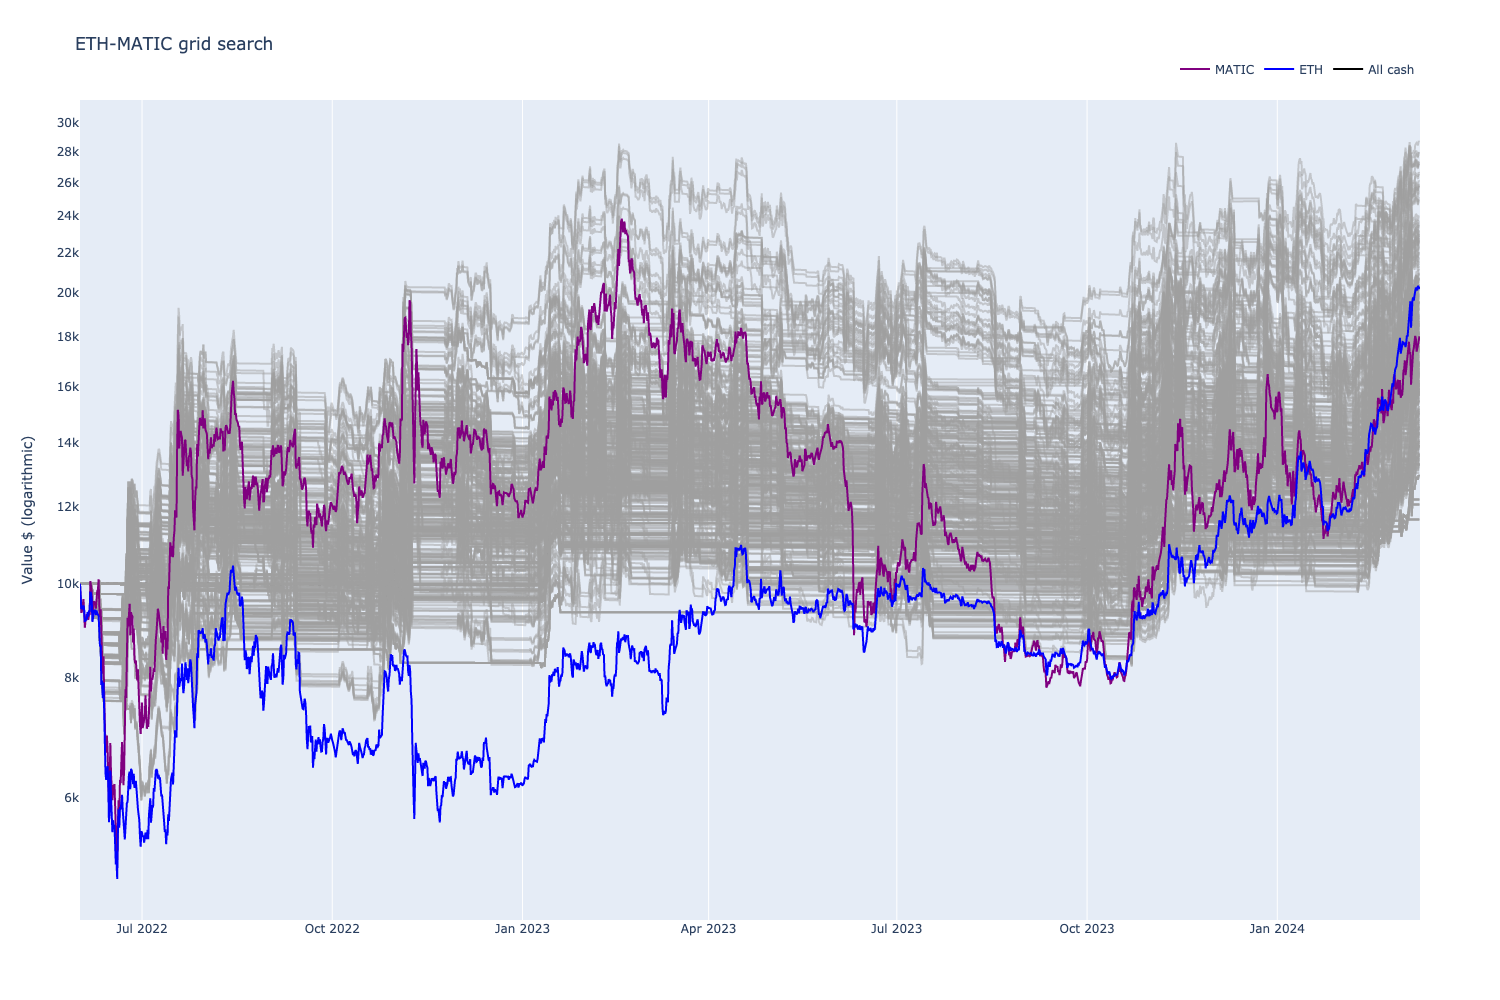

In [12]:
from tradeexecutor.analysis.grid_search import visualise_grid_search_equity_curves
from tradeexecutor.visual.benchmark import create_benchmark_equity_curves

benchmark_indexes = create_benchmark_equity_curves(
    strategy_universe,
    {"MATIC": our_pairs[1], "ETH": our_pairs[0]},
    initial_cash=GridSearchStrategyParameters.initial_cash,
)

benchmark_indexes["MATIC"].attrs = {"colour": "purple", "name": "Buy and hold MATIC"}
benchmark_indexes["ETH"].attrs = {"colour": "blue", "name": "Buy and hold ETH"}

filtered_results = [r for r in grid_search_results if (r.get_sharpe() > 0.75)]
# filtered_results = grid_search_results
print(f"We have {len(filtered_results)} results")

fig = visualise_grid_search_equity_curves(
    filtered_results,
    name="ETH-MATIC grid search",
    benchmark_indexes=benchmark_indexes,
    log_y=True,
)
fig.show()

## Returns comparison

- Check the ratio of returns strategy vs. benchmark indices
- See if there is trend in the strategy performance vs. benchmarks over time

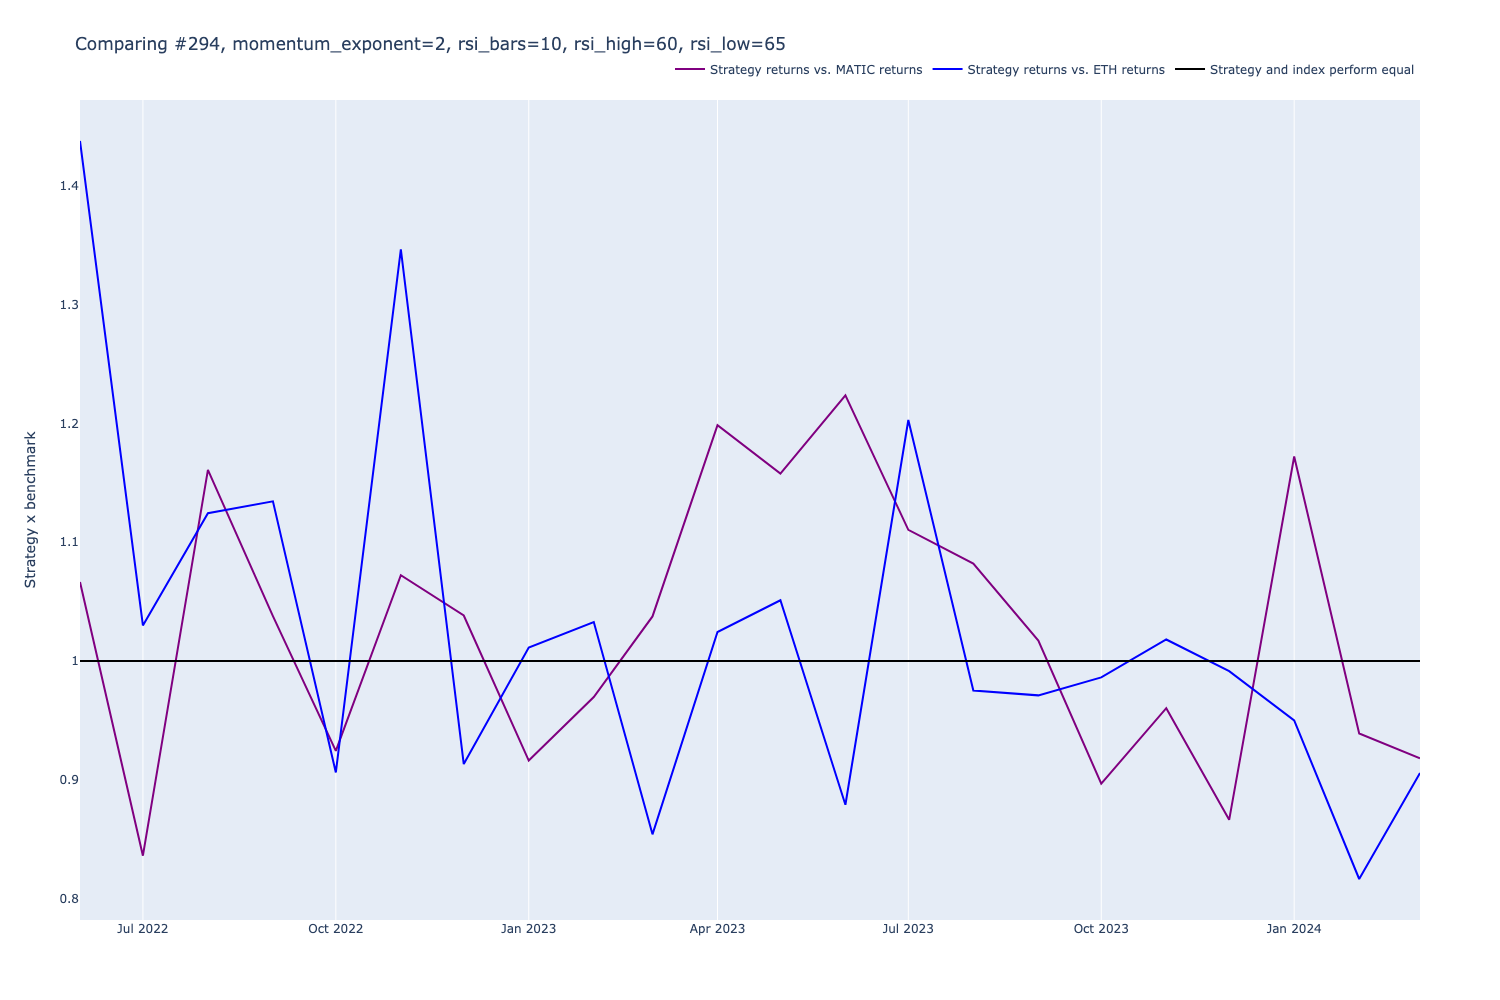

In [13]:
from pandas.tseries.offsets import QuarterBegin, MonthBegin

from tradeexecutor.visual.benchmark import visualise_vs_returns

best_result = best_results.cagr[0]
returns = best_result.returns

fig = visualise_vs_returns(
    returns,
    benchmark_indexes,
    freq=MonthBegin(),
    name=f"Comparing {best_result.get_label()}",
)
fig.show()

## Rolling Sharpe

- How the Sharpe ratio is evolving over time

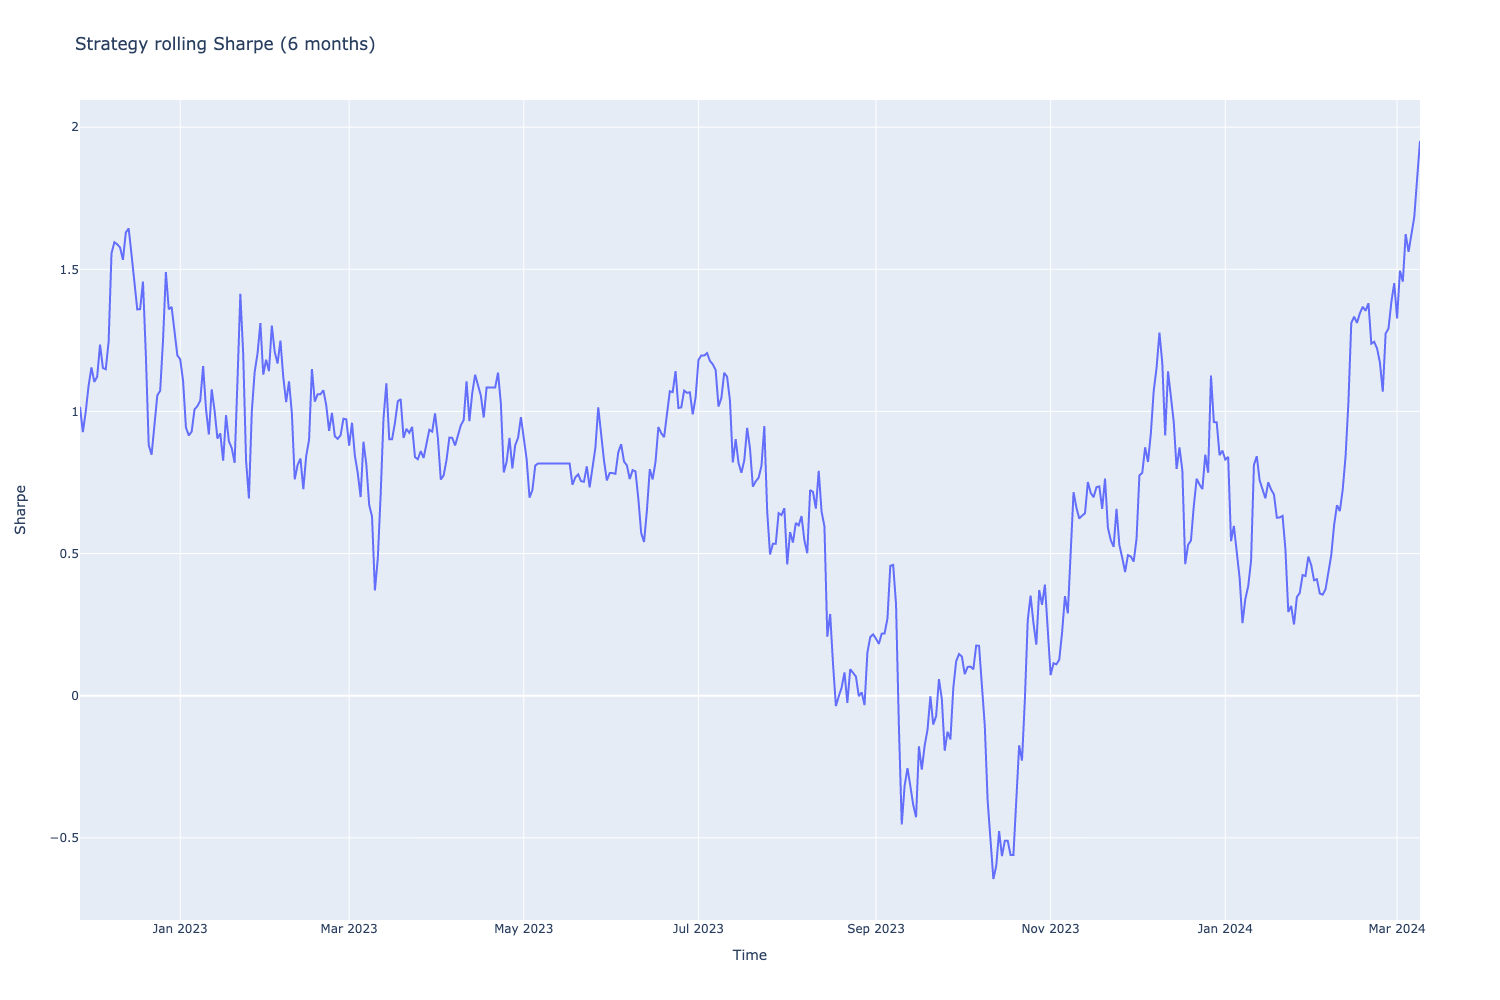

In [14]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()

## Performance sheet



In [16]:
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics

visualise_advanced_metrics(
    best_result.returns,
    benchmark=benchmark_indexes["ETH"],
    convert_to_daily=True,
)

Strategy Buy and hold ETH
Start Period        2022-06-01       2022-06-01
End Period          2024-03-09       2024-03-09
Risk-Free Rate            0.0%             0.0%
Time in Market           79.0%           100.0%
Cumulative Return      186.47%          114.81%
CAGR﹪                   81.07%           53.93%
Sharpe                    1.32             0.99
Prob. Sharpe Ratio      96.65%           90.52%
Sortino                   2.22             1.46
Sortino/√2                1.57             1.03
Omega                     1.26             1.26
Max Drawdown           -27.36%          -46.49%
Longest DD Days            117              242
Gain/Pain Ratio           0.26             0.17
Gain/Pain (1M)            2.06             1.14
Payoff Ratio              1.27             1.43
Profit Factor             1.26             1.17
Common Sense Ratio        1.56             1.42
CPC Index                 0.79             0.84
Tail Ratio                1.24             1.22
Outlier Win Ratio         6.36             4.37
Outlier Loss Ratio        4.24             4.07
MTD                      5.99%           16.92%
3M                      20.75%           65.56%
6M                      67.34%          138.64%
YTD                     20.34%           71.14%
1Y                      64.73%          154.85%
3Y (ann.)               81.07%           53.93%
5Y (ann.)               81.07%           53.93%
10Y (ann.)              81.07%           53.93%
All-time (ann.)         81.07%           53.93%
Avg. Drawdown           -8.97%          -10.76%
Avg. Drawdown Days          19               38
Recovery Factor           6.81             2.47
Ulcer Index                0.1             0.22
Serenity Index            2.88             0.48